In [1]:
#Imports

import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

In [2]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [3]:
x_train_flat.shape

(60000, 784)

In [4]:
def plot_singular_values(matrix, idx):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    return sig

## Regular Training

In [5]:
#Config
eps_train = 0.1
eps_test = 0.1
tensorboard_dir = "tb/"
weights_dir = "weights/"

load_counter = 58
sigma = tf.nn.relu

scope_name = "model_non_robust"

In [6]:
with tf.variable_scope(scope_name) as scope:
    sess = tf.Session()
    logdir = tensorboard_dir + str(counter) + "/non_robust"

    #Create, train and test model
    writer = tf.summary.FileWriter(logdir)
    model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
    logger.info("Created model successfully. Now going to load weights")

    #Restore weights
    weights = tf.trainable_variables()
    saver = tf.train.Saver(weights)
    weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

    writer.add_graph(sess.graph)

    loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
    logger.info("----Regular test accuracy and loss ----")
    logger.info((loss_reg, acc_reg))

    
    with tf.variable_scope("testing_benign") as scope:
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))


    with tf.variable_scope("testing_adversarial") as scope:
        loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
        logger.info("----FGSM test accuracy and loss ----")
        logger.info((loss_fgsm, acc_fgsm))
        x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)


    #Distances and norms

    if False:
        norms = get_norms(model.get_weights()[0])
        norms_np = sess.run(norms)
        logger.info(norms_np)
        overall, overall_std, correct, _, incorrect, _ = model.get_distance(sess, eps_test, x_test_flat, y_test)
        logger.info("---Distances----")
        logger.info(overall)
        logger.info("------Std devs on Distances----")
        logger.info(overall_std)


    if False:
        #TSNE visualization of final layer.
        x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
        metadata_path = os.path.join(logdir, 'metadata.tsv')
        write_metadata(metadata_path, y_test_ogi[0:1000])
        sprite_path = os.path.join(logdir, 'sprite_images.png')
        write_sprite_image(sprite_path, x_test_ogi[0:1000])
        model.visualize_activation_tsne(sess, x_test_flat_adv[0:1000], 'metadata.tsv', 'sprite_images.png', logdir)


Initialized instance variables of the robust model class
I0820 14:38:05.776288 4549854656 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0820 14:38:05.777712 4549854656 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0820 14:38:05.782169 4549854656 feedforward_robust.py:36] Created placeholders for x and y
W0820 14:38:05.783717 4549854656 deprecation_wrapper.py:119] From ../util/util.py:31: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0820 14:38:05.784451 4549854656 deprecation_wrapper.py:119] From ../util/util.py:31: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0820 14:38:05.786277 4549854656 deprecation_wrapper.py:119] From ../util/util.py:33: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W08

In [7]:
with tf.variable_scope(scope_name) as scope:
    weights = model.get_weights_np(sess)

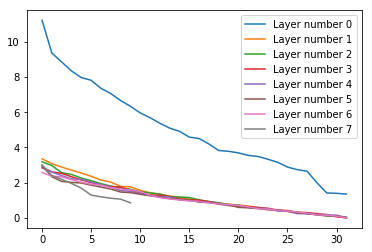

In [8]:
sing_vals = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx)
        sing_vals.append(sig)

In [9]:
sing_vals

[array([11.219591 ,  9.356054 ,  8.853931 ,  8.339419 ,  7.9637704,
         7.8134637,  7.3564215,  7.058405 ,  6.66576  ,  6.3353806,
         5.959866 ,  5.688879 ,  5.37518  ,  5.0967546,  4.916018 ,
         4.587053 ,  4.5058117,  4.1946373,  3.826147 ,  3.7809627,
         3.6920755,  3.5512054,  3.4865568,  3.3326955,  3.158114 ,
         2.8874547,  2.7380967,  2.6529348,  1.9937172,  1.4182587,
         1.3975704,  1.3518547], dtype=float32),
 array([3.3555133 , 3.0770993 , 2.8867211 , 2.7135534 , 2.546874  ,
        2.3628848 , 2.154325  , 2.0367765 , 1.7889944 , 1.7673813 ,
        1.5701079 , 1.4319557 , 1.3497653 , 1.2428688 , 1.1750933 ,
        1.0686702 , 0.9814576 , 0.8870417 , 0.8434903 , 0.7797669 ,
        0.7305877 , 0.6794515 , 0.58738804, 0.4739951 , 0.4635789 ,
        0.3811394 , 0.31063223, 0.3000163 , 0.18293275, 0.12966576,
        0.1047547 , 0.02554336], dtype=float32),
 array([3.190353  , 2.9698312 , 2.5693169 , 2.4689467 , 2.2635596 ,
        2.1147387 

# Adversarial Training

In [10]:
#Config
eps_train = 0.1
eps_test = 0.1
tensorboard_dir = "tb/"
weights_dir = "weights/"

load_counter = 75
sigma = tf.nn.relu

scope_name_rob = "model_robust"

In [11]:
sess = tf.Session()
hidden_sizes = [32,32,32,32,32,32,32]
dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

with tf.variable_scope(scope_name_rob) as scope:
    logdir = tensorboard_dir + str(counter) + "/robust"
    writer_robust = tf.summary.FileWriter(logdir)
    logger.info("Adversarial Training")
    robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
    sess.run(tf.global_variables_initializer())
    robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)

    loss_reg, acc_reg = robust_model.evaluate(sess, x_test_flat, y_test)
    loss_adv, acc_adv = robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test)

Adversarial Training
Initialized instance variables of the robust model class
Created placeholders for x and y
Created layers and tensor for logits
Added loss computation to the graph
Added accuracy computation to the graph
Model graph was created


Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


Epoch: 0001    cost: 1.747022671 
Accuracy on batch: 0.500000
Epoch: 0002    cost: 1.251095908 
Accuracy on batch: 0.625000
Epoch: 0003    cost: 1.091098627 
Accuracy on batch: 0.625000
Epoch: 0004    cost: 0.990394628 
Accuracy on batch: 0.625000
Epoch: 0005    cost: 0.919445833 
Accuracy on batch: 0.687500
Epoch: 0006    cost: 0.861593112 
Accuracy on batch: 0.750000
Epoch: 0007    cost: 0.815461590 
Accuracy on batch: 0.687500
Epoch: 0008    cost: 0.773315189 
Accuracy on batch: 0.750000
Epoch: 0009    cost: 0.734800246 
Accuracy on batch: 0.781250
Epoch: 0010    cost: 0.701817893 
Accuracy on batch: 0.781250
Epoch: 0011    cost: 0.680446160 
Accuracy on batch: 0.812500
Epoch: 0012    cost: 0.657826241 
Accuracy on batch: 0.812500
Epoch: 0013    cost: 0.638760420 
Accuracy on batch: 0.750000
Epoch: 0014    cost: 0.618658794 
Accuracy on batch: 0.812500
Epoch: 0015    cost: 0.602766878 
Accuracy on batch: 0.781250
Epoch: 0016    cost: 0.588350449 
Accuracy on batch: 0.781250
Epoch: 0

In [12]:
loss_reg, acc_reg

(0.28142613, 0.9175)

In [13]:
loss_adv, acc_adv

(0.56064105, 0.8189)

In [14]:
with tf.variable_scope(scope_name) as scope:
    weights_robust = robust_model.get_weights_np(sess)

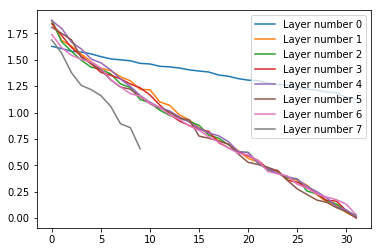

In [15]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx)
    sing_vals_robust.append(sig)

In [16]:
sing_vals[0]

array([11.219591 ,  9.356054 ,  8.853931 ,  8.339419 ,  7.9637704,
        7.8134637,  7.3564215,  7.058405 ,  6.66576  ,  6.3353806,
        5.959866 ,  5.688879 ,  5.37518  ,  5.0967546,  4.916018 ,
        4.587053 ,  4.5058117,  4.1946373,  3.826147 ,  3.7809627,
        3.6920755,  3.5512054,  3.4865568,  3.3326955,  3.158114 ,
        2.8874547,  2.7380967,  2.6529348,  1.9937172,  1.4182587,
        1.3975704,  1.3518547], dtype=float32)

In [17]:
sing_vals_robust[0]

array([1.6281346, 1.6064076, 1.5809422, 1.5732507, 1.5560015, 1.529831 ,
       1.5089031, 1.4993364, 1.4906206, 1.4659523, 1.4602592, 1.4382168,
       1.4325268, 1.4218315, 1.4042149, 1.3935497, 1.383603 , 1.3556856,
       1.3435506, 1.3207132, 1.3071383, 1.3004727, 1.281328 , 1.2648687,
       1.2587713, 1.2393578, 1.2225584, 1.2128881, 1.1946394, 1.187412 ,
       1.1400943, 1.1278031], dtype=float32)

In [18]:
sing_vals[1]

array([3.3555133 , 3.0770993 , 2.8867211 , 2.7135534 , 2.546874  ,
       2.3628848 , 2.154325  , 2.0367765 , 1.7889944 , 1.7673813 ,
       1.5701079 , 1.4319557 , 1.3497653 , 1.2428688 , 1.1750933 ,
       1.0686702 , 0.9814576 , 0.8870417 , 0.8434903 , 0.7797669 ,
       0.7305877 , 0.6794515 , 0.58738804, 0.4739951 , 0.4635789 ,
       0.3811394 , 0.31063223, 0.3000163 , 0.18293275, 0.12966576,
       0.1047547 , 0.02554336], dtype=float32)

In [19]:
sing_vals_robust[1]

array([1.8701458 , 1.6838324 , 1.6297264 , 1.5546918 , 1.4825531 ,
       1.4205524 , 1.3963453 , 1.3386055 , 1.3004792 , 1.2189486 ,
       1.2158065 , 1.1005108 , 1.0682665 , 0.97767437, 0.92988646,
       0.8537934 , 0.79262215, 0.73411745, 0.6967281 , 0.63778067,
       0.56476533, 0.5298053 , 0.46536067, 0.43751535, 0.3764206 ,
       0.35791627, 0.3105542 , 0.21878439, 0.15280338, 0.1198618 ,
       0.05032936, 0.00436161], dtype=float32)

In [20]:
sing_vals[2]

array([3.190353  , 2.9698312 , 2.5693169 , 2.4689467 , 2.2635596 ,
       2.1147387 , 1.9464352 , 1.807925  , 1.7158626 , 1.6282052 ,
       1.4895344 , 1.4230894 , 1.3509948 , 1.2100762 , 1.1883975 ,
       1.1575755 , 1.0261064 , 0.9290708 , 0.86253023, 0.76148295,
       0.72430235, 0.61824846, 0.55077726, 0.5103169 , 0.43055552,
       0.38944536, 0.3188387 , 0.23886074, 0.20708954, 0.12144791,
       0.08276477, 0.04309303], dtype=float32)

In [21]:
sing_vals_robust[2]

array([1.8750039 , 1.6711195 , 1.5805936 , 1.4966657 , 1.4297006 ,
       1.4105421 , 1.3658987 , 1.2716576 , 1.2368332 , 1.1233637 ,
       1.0930353 , 1.021906  , 0.9724935 , 0.94561726, 0.91638786,
       0.8786969 , 0.78482324, 0.7566797 , 0.69408274, 0.6268401 ,
       0.6219102 , 0.52096033, 0.4551776 , 0.4222853 , 0.37909722,
       0.3705383 , 0.2548319 , 0.22732516, 0.16269998, 0.13239738,
       0.06489643, 0.02497203], dtype=float32)

In [22]:
sing_vals[-1]

array([3.005259 , 2.409253 , 2.191596 , 1.9573574, 1.6897454, 1.2956517,
       1.1981667, 1.1196339, 1.0656364, 0.8578519], dtype=float32)

In [23]:
sing_vals_robust[-1]

array([1.6885461 , 1.5633739 , 1.3775584 , 1.2570375 , 1.2174962 ,
       1.1604171 , 1.0587909 , 0.8933346 , 0.85591596, 0.6555433 ],
      dtype=float32)

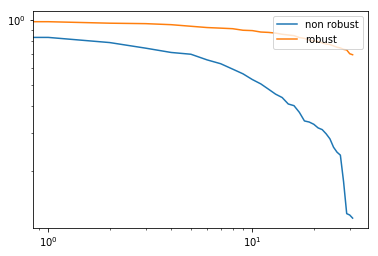

In [28]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

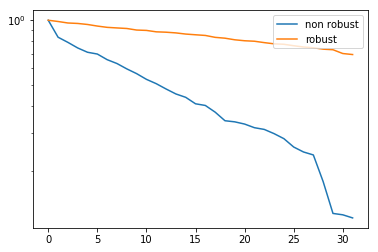

In [29]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

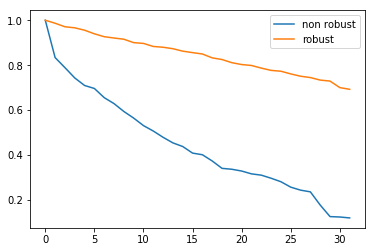

In [30]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [40]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [41]:
num_layers = len(sing_vals)

In [42]:
num_layers

8

0
-----------
-----NORM FACTOR NON---
11.219591
-----NORM FACTOR ROB---
1.6281346


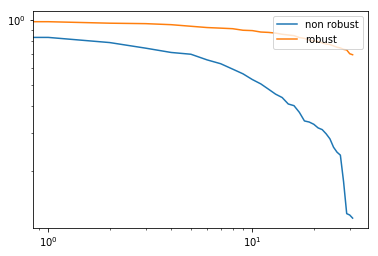

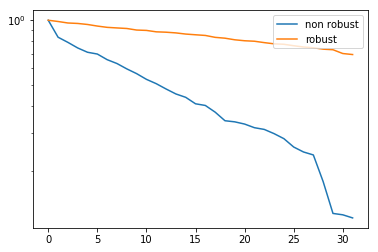

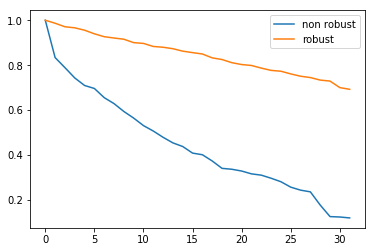

-----------
1
-----------
-----NORM FACTOR NON---
3.3555133
-----NORM FACTOR ROB---
1.8701458


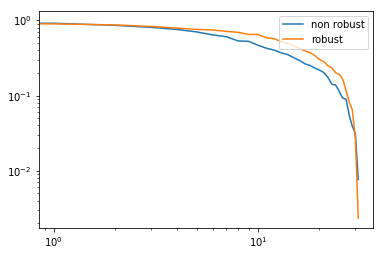

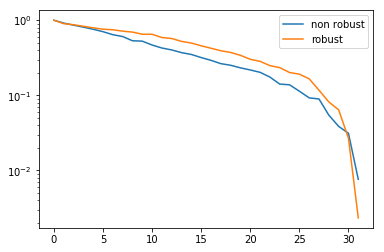

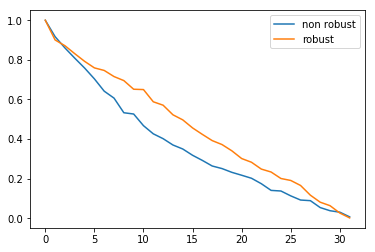

-----------
2
-----------
-----NORM FACTOR NON---
3.190353
-----NORM FACTOR ROB---
1.8750039


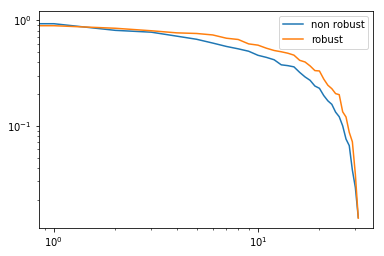

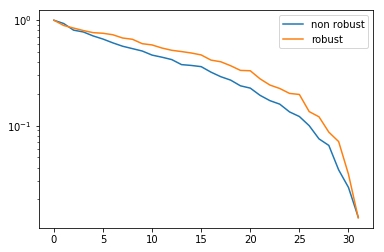

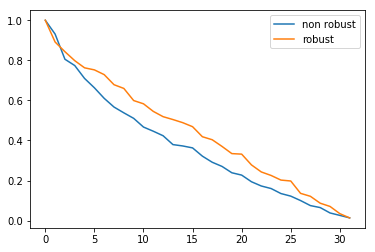

-----------
3
-----------
-----NORM FACTOR NON---
2.8452258
-----NORM FACTOR ROB---
1.8420991


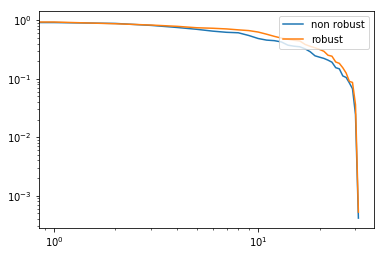

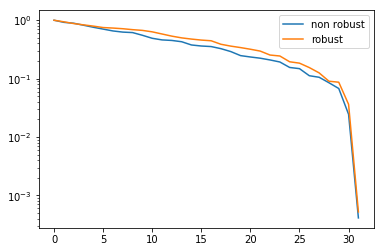

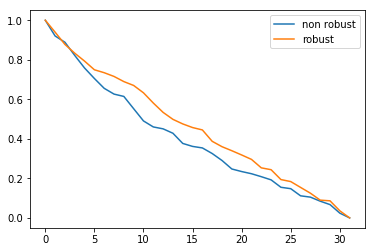

-----------
4
-----------
-----NORM FACTOR NON---
2.901472
-----NORM FACTOR ROB---
1.8710623


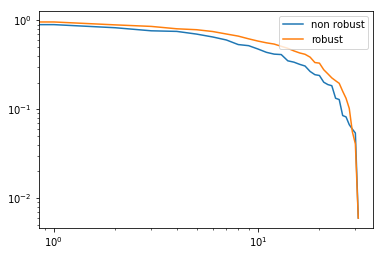

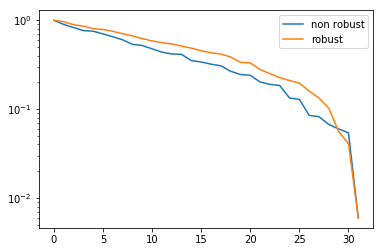

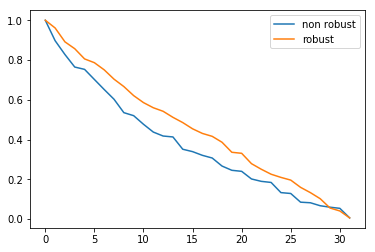

-----------
5
-----------
-----NORM FACTOR NON---
2.9760718
-----NORM FACTOR ROB---
1.8087798


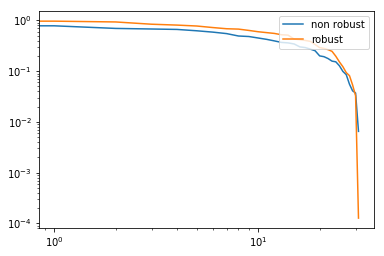

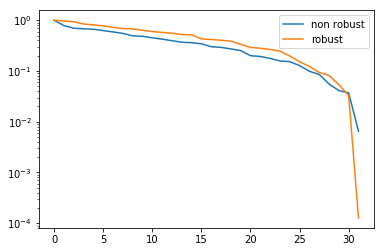

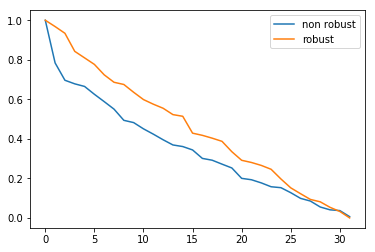

-----------
6
-----------
-----NORM FACTOR NON---
2.5741491
-----NORM FACTOR ROB---
1.7410454


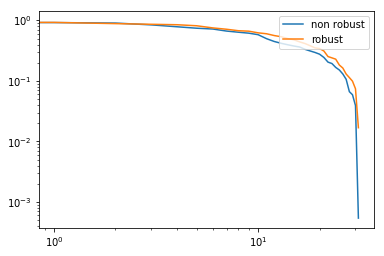

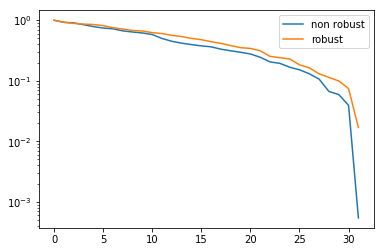

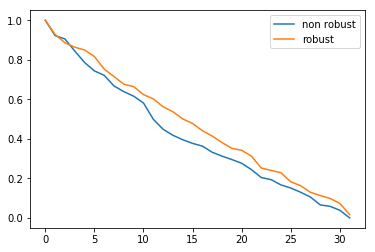

-----------
7
-----------
-----NORM FACTOR NON---
3.005259
-----NORM FACTOR ROB---
1.6885461


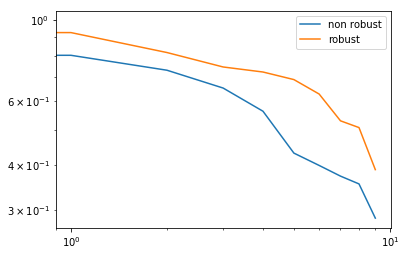

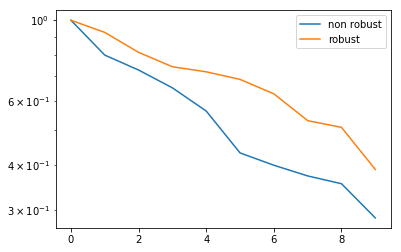

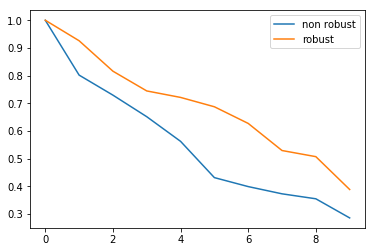

-----------


In [43]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")